---
layout: default
title: "Deep Learning - Speed up learning - Other optimization techinques"
categories: deeplearning
permalink: /ML30/
order: 30
comments: true
---

In [28]:
%pylab --no-import-all inline
from plot_ann import ann
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/home/marnec/.local/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# More sophisticated optimization techniques
There are other more sophisticated optimization techniques than gradient descent, in order to talk about them let's introduce **exponentially weighted averages**

## Exponentially weighted averages
Let's take the average daily temperature in London across the year 2019 (<a href="#londtemp">figure below</a>)

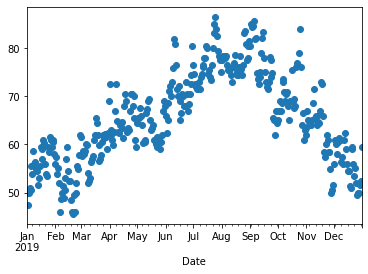

In [57]:
df = pd.read_csv('data/temps.csv', index_col=[0], parse_dates=[0], usecols=[1, 2, 3])\
.loc['2019']\
.mean(axis=1)\
.dropna()
df.plot(ls='none', marker='o');

<i id="londtemp">Average daily temperatures in the year 2019 in London</i>

The data looks noisy and in order to compute the trend of the temperature across the year we can use the following approach. Starting from the first day $v_0=0$ we can proceed by averaging:

$$
\begin{aligned}
&v_0=0\\
&v_1 = 0.9v_0 + 0.1 \theta_1 \\
&v_2 = 0.9v_1 + 0.1 \theta_2 \\
&v_3 = 0.9v_3 + 0.1 \theta_3 \\
& \vdots \\
&v_t = 0.9v_{t-1} + 0.1 \theta_t \\
\end{aligned}
$$

where $\theta_i$ is current temperature.

Let's rewrite the generalization as:

$$
\begin{equation}
v_t = \beta v_{t-1} + (1-\beta) \theta_t
\end{equation}
\label{eq:ewa} \tag{1}
$$

We can think of $v_t$ as approximately averaging over $\frac{1}{1-\beta}$ days, so when using:

* $\beta = 0.9 \to \frac{1}{1-0.9} \approx$ average 10 over days
* $\beta = 0.98 \to \frac{1}{1-0.98} \approx$ average over 50 days
* $\beta = 0.5 \to \frac{1}{1-5} \approx$ average over 2 days

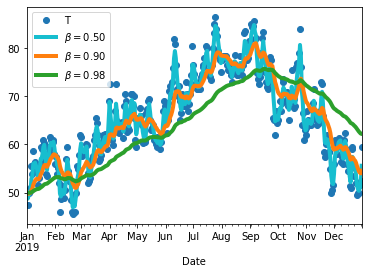

In [102]:
ax = plt.gca()
df.plot(ls='none', marker='o', ax=ax, label='T')
df.ewm(alpha=.5, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.50$', c='C9')
df.ewm(alpha=.1, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.90$')
df.ewm(alpha=.02, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.98$')

ax.legend();

<i id="ewa">Exponentially weighted average applied to raw data with different values of $\beta$</i>

As we can see in <a href="#ewa">the figure above</a>, increasing values of $\beta$ will produce smoother trends but on the flipside, we can notice that the smoothest trend is also shifted towards the right, since the rolling windows (the number of days on which each point is averaged on) is bigger and adapts more slowly to how the temperature changes. In fact, by setting a large $\beta$, we are giving a greater weight to the temperatures that have come before ($v_t$) and a smaller weight to the current temperature.

The equation in $\eqref{eq:ewa}$ is how you implement an **exponentially weighted moving average** or exponentially weighted average for short.